# Produce lifetime XY map

<i>
This notebook takes a clean kDST, measures the lifetime at
different points of the XY plane and stores this map in
a hdf5 file.
</i>

### Imports

In [2]:
import os
import glob
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-03-16 10:13:44


In [187]:
from icaro.core.fit_functions import conditional_labels

In [188]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
with_titles = True
labels = conditional_labels(with_titles)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
from invisible_cities.icaro. hst_functions import plot_writer

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import fit_slices_2d_expo
from icaro.core.fit_functions import expo_seed, gauss_seed
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels
from icaro.core.fit_functions import fit_profile_1d_expo

In [132]:
from   invisible_cities.evm  .ic_containers  import Measurement

In [5]:
from typing      import NamedTuple
from typing      import Tuple

In [6]:
from core.kr_functions import KrEvent, KrRanges, KrNBins, KrBins, KrFit, Ranges
import core.kr_functions as krf

### Notebook configuration

In [14]:
run_number          = 5406
input_dsts_filename = f"/Users/jjgomezcadenas/Projects/ICDEV/dsts/{run_number}"
correction_filename = f"/Users/jjgomezcadenas/Projects/ICDEV/maps/lifetime_map_{run_number}.h5"


# Plotting style
default_cmap = "jet"
figure_size  = 16, 12
font_size    = 15

save_plots   = True
with_titles  = False
plots_format = "pdf"

### Initialization

In [15]:
nsdst, dst_full= krf.read_dsts(input_dsts_filename)

In [16]:
ntot = len(nsdst)
print(f'DST has {ntot} events')

DST has 1240894 events


In [17]:
krf.print_ns12_stats(*krf.ns1_stats(nsdst))

ns12: mean =  2.08 sigma =  7.75
ns12 : fraction
0:  0.05
1:  0.48
2:  0.27
3:  0.11
4:  0.09


In [18]:
krf.print_ns12_stats(*krf.ns2_stats(nsdst))

ns12: mean =  1.06 sigma =  0.35
ns12 : fraction
0:  0.00
1:  0.94
2:  0.06
3:  0.00


In [20]:
dst1s1 = dst_full[dst_full.ns1==1]

In [22]:
dst = dst1s1[dst1s1.ns2==1]

In [26]:
ns1dst = nsdst[nsdst.ns1==1]
ndst = ns1dst[ns1dst.ns2==1]
ntot = len(ndst)
print(f' filteres DST has {ntot} events')

 filteres DST has 562002 events


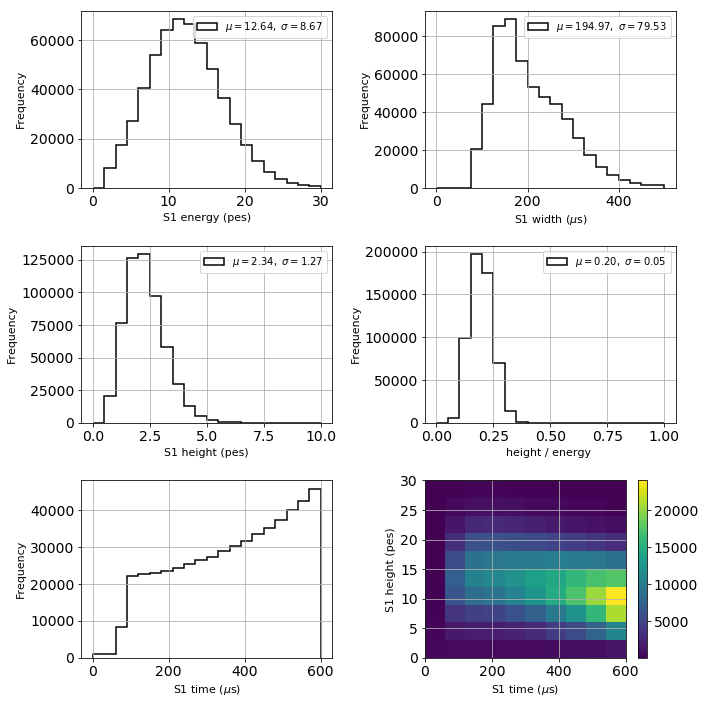

In [27]:
krf.plot_s1histos(dst, bins=20, figsize=(10,10))

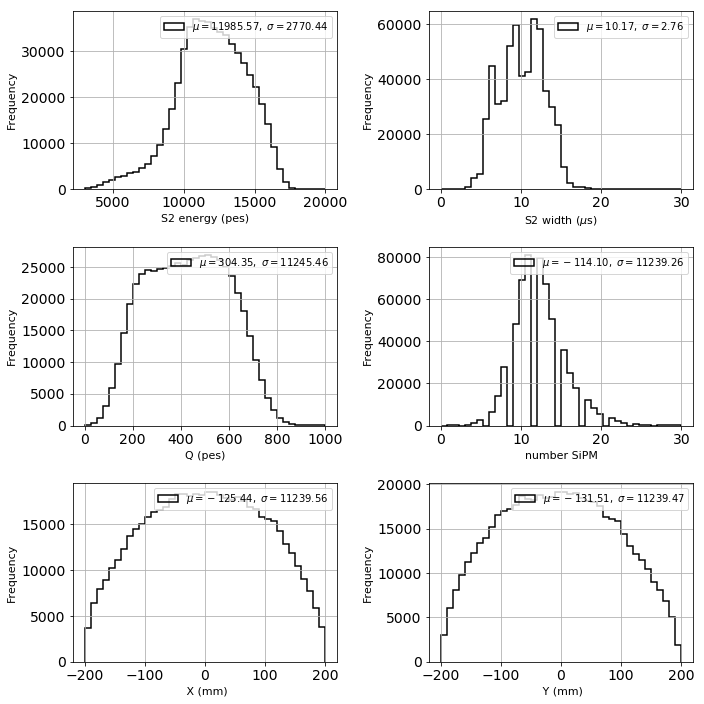

In [28]:
krf.plot_s2histos(dst, bins=40, emin=3000, emax=20000, figsize=(10,10))

### Event distribution

In [81]:
kre  = KrEvent(E = dst.es2.values,
              Q = dst.qs2.values,             
              X = dst.xs2  .values,
              Y = dst.ys2  .values,
              Z = dst.ts2  .values - dst.ts1  .values
              )



In [299]:
ok   = kre.Q > 0
out  = np.zeros(kre.E.shape, dtype=float)
eovQ = np.divide(kre.E, kre.Q, out=out, where=ok)

In [301]:
eovQ.shape

(562002,)

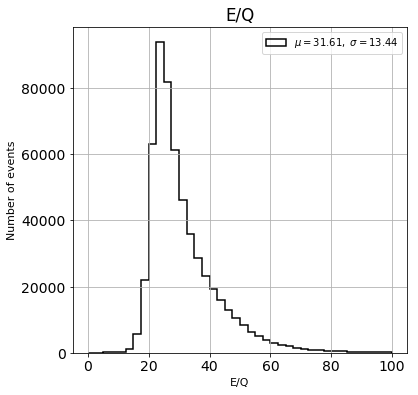

In [303]:
krf.h1d(eovQ, bins=40, range=(0,100), xlabel='E/Q', ylabel='Number of events',
        title='E/Q', legend='upper right', figsize=(6,6))



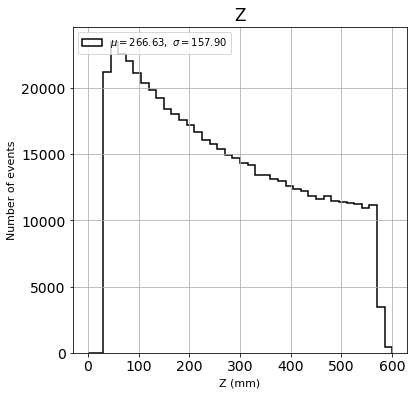

In [91]:
krf.h1d(kre.Z, bins=40, range=(0,600), xlabel='Z (mm)', ylabel='Number of events',
        title='Z', legend='upper left', figsize=(6,6))



In [208]:
kR = KrRanges(E  = ( 4e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-200, 200)
             )

kNB = KrNBins(E  =  50,
              Q  =  25,
              Z  =  10,
              XY =  40
             )
kB  = KrBins(E   =  np.linspace(*kR.E,  kNB.E  + 1),
             Q   =  np.linspace(*kR.Q,  kNB.Q  + 1),
             Z   =  np.linspace(*kR.Z,  kNB.Z  + 1),
             XY  =  np.linspace(*kR.XY, kNB.XY + 1),
             cXY =  shift_to_bin_centers(np.linspace(*kR.XY, kNB.XY + 1))
            )          

In [209]:
kB

KrBins(E=array([  4000.,   4280.,   4560.,   4840.,   5120.,   5400.,   5680.,
         5960.,   6240.,   6520.,   6800.,   7080.,   7360.,   7640.,
         7920.,   8200.,   8480.,   8760.,   9040.,   9320.,   9600.,
         9880.,  10160.,  10440.,  10720.,  11000.,  11280.,  11560.,
        11840.,  12120.,  12400.,  12680.,  12960.,  13240.,  13520.,
        13800.,  14080.,  14360.,  14640.,  14920.,  15200.,  15480.,
        15760.,  16040.,  16320.,  16600.,  16880.,  17160.,  17440.,
        17720.,  18000.]), Q=array([   0.,   32.,   64.,   96.,  128.,  160.,  192.,  224.,  256.,
        288.,  320.,  352.,  384.,  416.,  448.,  480.,  512.,  544.,
        576.,  608.,  640.,  672.,  704.,  736.,  768.,  800.]), Z=array([ 100.,  140.,  180.,  220.,  260.,  300.,  340.,  380.,  420.,
        460.,  500.]), XY=array([-200., -190., -180., -170., -160., -150., -140., -130., -120.,
       -110., -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,
        -20.,  -10.,    0.,  

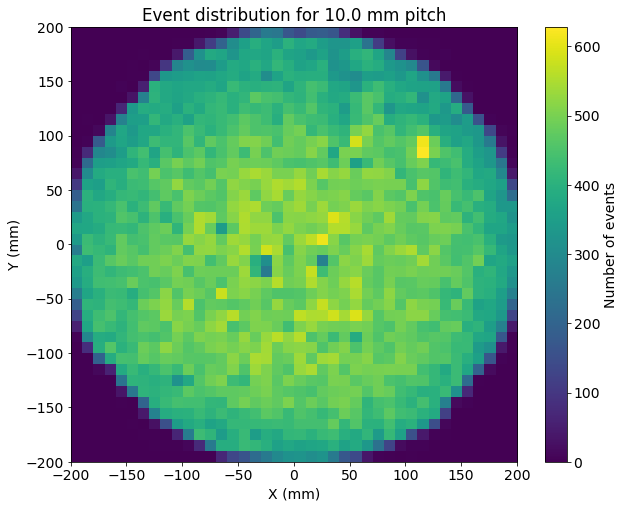

In [210]:
nevt = krf.xy_event_map(kre, kB)

### Compute lifetime maps

fit par[0] = 16647.92749617606 error = 6.543151421890886
fit par[1] = -1166.588329021039 error = 2.0868779290269863
chi2 = 1.2818398716255468


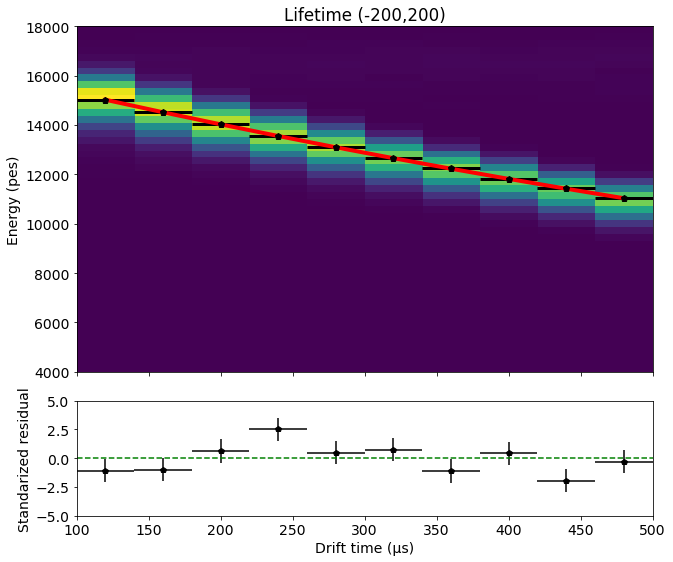

In [226]:
kL = KrRanges(E  = ( 8e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-100, 100)
             )

lt, lte, chi2, OK = krf.fit_lifetime_from_profile(kre, kR, kNB, kB, kL, 
                                 title="Lifetime (-200,200)")

In [ ]:
kR = KrRanges(E  = ( 4e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-190, 190)
             )

kNB = KrNBins(E  =  50,
              Q  =  25,
              Z  =  30,
              XY =  30
             )
kB  = KrBins(E   =  np.linspace(*kR.E,  kNB.E  + 1),
             Q   =  np.linspace(*kR.Q,  kNB.Q  + 1),
             Z   =  np.linspace(*kR.Z,  kNB.Z  + 1),
             XY  =  np.linspace(*kR.XY, kNB.XY + 1),
             cXY =  shift_to_bin_centers(np.linspace(*kR.XY, kNB.XY + 1))
            )          

In [260]:
E, LT, chi2, ok = krf.fit_lifetimes_from_profile(kre,
                                                 kR,
                                                 kNB,
                                                 kB,
                                                 kL,
                                                 min_entries = 50)

In [277]:
Eok        = in_range(LT.value, 100, 1e+4) 

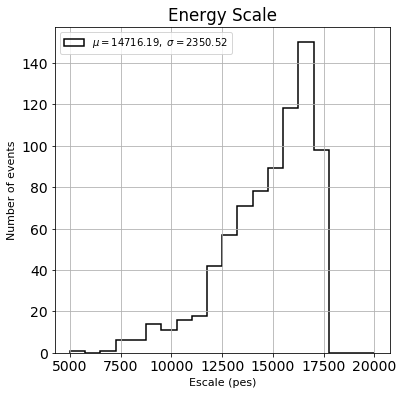

In [278]:
krf.h1d(E.value[Eok].flatten(), bins=20, range=(5000,20000), xlabel='Escale (pes)', ylabel='Number of events',
        title='Energy Scale', legend='upper left', figsize=(6,6))



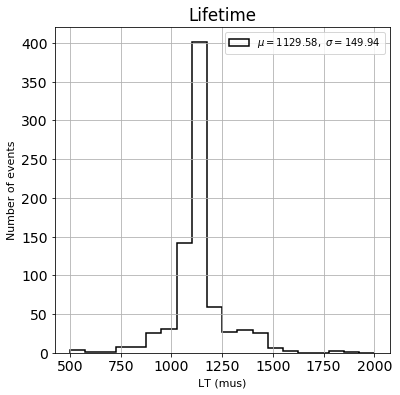

In [279]:
krf.h1d(LT.value[Eok].flatten(), bins=20, range=(500,2000), xlabel='LT (mus)', ylabel='Number of events',
        title='Lifetime', legend='upper right', figsize=(6,6))




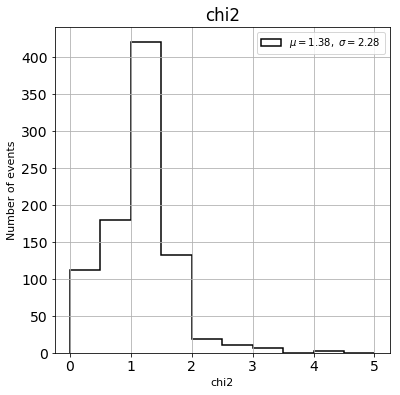

In [280]:
krf.h1d(chi2.flatten(), bins=10, range=(0,5), xlabel='chi2', ylabel='Number of events',
        title='chi2', legend='upper right', figsize=(6,6))


In [281]:
Escale     = to_relative(E, percentual=True)
ELT        = to_relative(LT, percentual=True)

In [282]:
ELT_mean  = np.nanmean(ELT   .value      [Eok])
ELT_std   = np.nanstd (ELT   .value      [Eok])
ELTu_mean = np.nanmean(ELT   .uncertainty[Eok])
ELTu_std  = np.nanstd (ELT   .uncertainty[Eok])

E_mean    = np.nanmean(Escale.value      [Eok])
E_std     = np.nanstd (Escale.value      [Eok])
Eu_mean   = np.nanmean(Escale.uncertainty[Eok])
Eu_std    = np.nanstd (Escale.uncertainty[Eok])


In [283]:
E_min    =        E_mean - 3.0 *    E_std
E_max    =        E_mean + 2.0 *    E_std

ELT_min  =     ELT_mean - 2.0 *  ELT_std
ELT_max  =     ELT_mean + 2.0 *  ELT_std

Eu_min   = max(  Eu_mean - 1.5 *   Eu_std, 1e-3)
Eu_max   =       Eu_mean + 2.0 *   Eu_std

ELTu_min = max(ELTu_mean - 1.5 * ELTu_std, 1e-3)
ELTu_max =     ELTu_mean + 2.0 * ELTu_std


In [284]:
print(f'E_min = {E_min} pes, E_max = {E_max} pes')
print(f'ELT_min = {ELT_min} mus, ELT_max = {ELT_max} mus')

E_min = 7664.623008581255 pes, E_max = 19417.24074545298 pes
ELT_min = 829.7029424303189 mus, ELT_max = 1429.455054072451 mus


### Map display

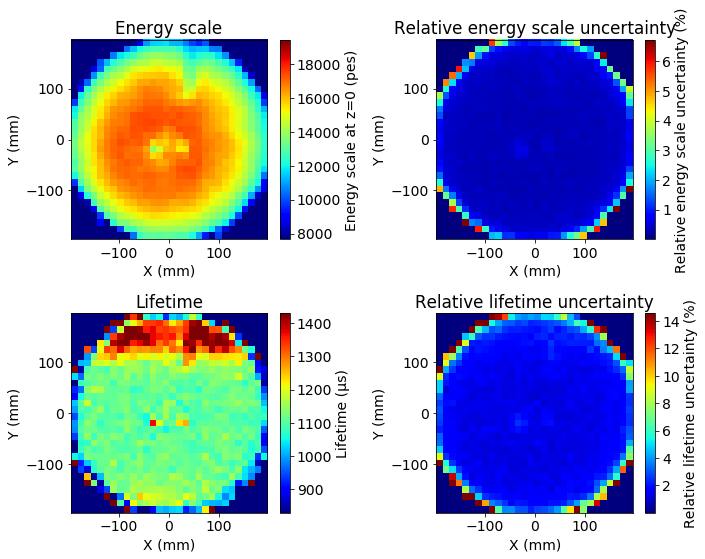

In [285]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(kB.cXY, kB.cXY, Escale.value,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Energy scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Energy scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(kB.cXY, kB.cXY, Escale.uncertainty,
                        vmin = Eu_min,
                        vmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative energy scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(kB.cXY, kB.cXY, ELT.value,
                        vmin = ELT_min,
                        vmax = ELT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(kB.cXY, kB.cXY, ELT.uncertainty,
                        vmin = ELTu_min,
                        vmax = ELTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()

In [286]:
kR = KrRanges(E  = ( 4e3, 18e3),
              Q  = (   0, 800),
              Z  = ( 100, 500),
              XY = (-100, 100)
             )

kNB = KrNBins(E  =  50,
              Q  =  25,
              Z  =  20,
              XY =  20
             )
kB  = KrBins(E   =  np.linspace(*kR.E,  kNB.E  + 1),
             Q   =  np.linspace(*kR.Q,  kNB.Q  + 1),
             Z   =  np.linspace(*kR.Z,  kNB.Z  + 1),
             XY  =  np.linspace(*kR.XY, kNB.XY + 1),
             cXY =  shift_to_bin_centers(np.linspace(*kR.XY, kNB.XY + 1))
            )          

In [287]:
E2, LT2, chi22, ok2 = krf.fit_lifetimes_from_profile(kre,
                                                 kR,
                                                 kNB,
                                                 kB,
                                                 kL,
                                                 min_entries = 50)

In [288]:
Eok2        = in_range(LT2.value, 100, 1e+4) 

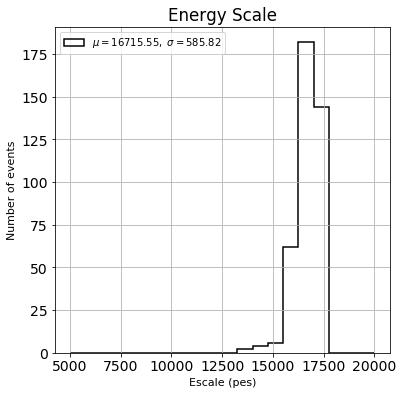

In [290]:
krf.h1d(E2.value[Eok2].flatten(), bins=20, range=(5000,20000), xlabel='Escale (pes)', ylabel='Number of events',
        title='Energy Scale', legend='upper left', figsize=(6,6))

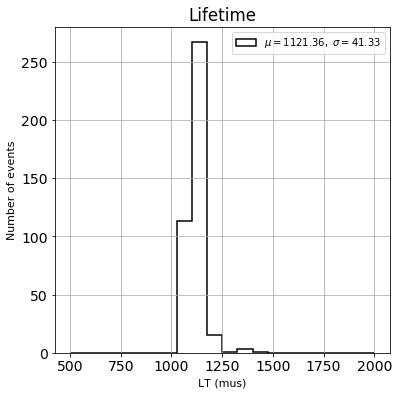

In [291]:
krf.h1d(LT2.value[Eok2].flatten(), bins=20, range=(500,2000), xlabel='LT (mus)', ylabel='Number of events',
        title='Lifetime', legend='upper right', figsize=(6,6))

In [294]:
Escale     = to_relative(E2, percentual=True)
ELT        = to_relative(LT2, percentual=True)
ELT_mean  = np.nanmean(ELT   .value      [Eok2])
ELT_std   = np.nanstd (ELT   .value      [Eok2])
ELTu_mean = np.nanmean(ELT   .uncertainty[Eok2])
ELTu_std  = np.nanstd (ELT   .uncertainty[Eok2])

E_mean    = np.nanmean(Escale.value      [Eok2])
E_std     = np.nanstd (Escale.value      [Eok2])
Eu_mean   = np.nanmean(Escale.uncertainty[Eok2])
Eu_std    = np.nanstd (Escale.uncertainty[Eok2])
E_min    =        E_mean - 3.0 *    E_std
E_max    =        E_mean + 2.0 *    E_std

ELT_min  =     ELT_mean - 2.0 *  ELT_std
ELT_max  =     ELT_mean + 2.0 *  ELT_std

Eu_min   = max(  Eu_mean - 1.5 *   Eu_std, 1e-3)
Eu_max   =       Eu_mean + 2.0 *   Eu_std

ELTu_min = max(ELTu_mean - 1.5 * ELTu_std, 1e-3)
ELTu_max =     ELTu_mean + 2.0 * ELTu_std
print(f'E_min = {E_min} pes, E_max = {E_max} pes')
print(f'ELT_min = {ELT_min} mus, ELT_max = {ELT_max} mus')


E_min = 14958.101296199065 pes, E_max = 17887.186493502504 pes
ELT_min = 1038.6988993799205 mus, ELT_max = 1204.0301899438928 mus


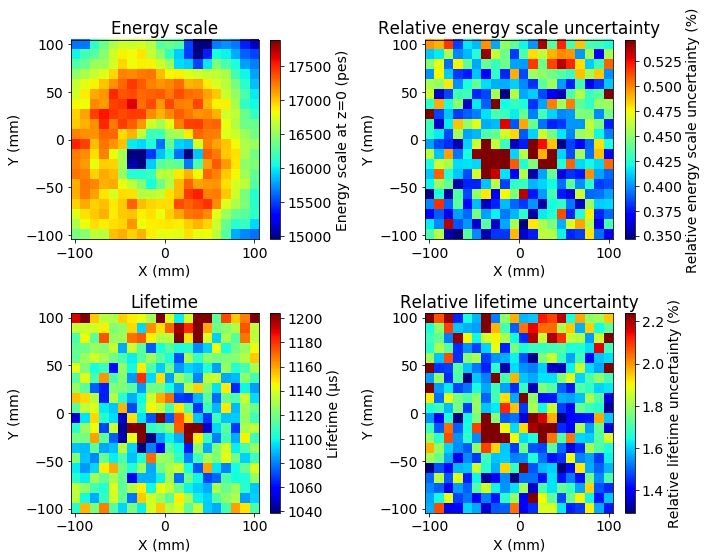

In [295]:
plt.subplot(2, 2, 1)
*_, cb = display_matrix(kB.cXY, kB.cXY, Escale.value,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Energy scale at z=0 (pes)")
labels("X (mm)", "Y (mm)", "Energy scale")

plt.subplot(2, 2, 2)
*_, cb = display_matrix(kB.cXY, kB.cXY, Escale.uncertainty,
                        vmin = Eu_min,
                        vmax = Eu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative energy scale uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative energy scale uncertainty")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(kB.cXY, kB.cXY, ELT.value,
                        vmin = ELT_min,
                        vmax = ELT_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Lifetime (µs)")
labels("X (mm)", "Y (mm)", "Lifetime")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(kB.cXY, kB.cXY, ELT.uncertainty,
                        vmin = ELTu_min,
                        vmax = ELTu_max,
                        cmap = default_cmap,
                        new_figure = False);
cb.set_label("Relative lifetime uncertainty (%)")
labels("X (mm)", "Y (mm)", "Relative lifetime uncertainty")

plt.tight_layout()

### Produce HDF5 output

In [ ]:
# This is to avoid the effect of low stat bins
# to the map. Data points in that bin could be
# loss or corrected with an unrealistic lifetime.
# Thus, we assign the average value. This works
# because correcting with a slightly different
# lifetime does not have a big impact on energy
# resolution.

Escale_safe  = np.where(Eok, Escale_abs.value      ,     E_mean)
Escaleu_safe = np.where(Eok, Escale_abs.uncertainty,    Eu_mean *   E_mean / 100)

ELT_safe     = np.where(Eok,   -ELT_abs.value      , - ELT_mean)
ELTu_safe    = np.where(Eok,    ELT_abs.uncertainty, -ELTu_mean * ELT_mean / 100)

Qscale_safe  = np.where(Qok, Qscale_abs.value      ,     Q_mean)
Qscaleu_safe = np.where(Qok, Qscale_abs.uncertainty,    Qu_mean *   Q_mean / 100)

QLT_safe     = np.where(Qok,   -QLT_abs.value      , - QLT_mean)
QLTu_safe    = np.where(Qok,    QLT_abs.uncertainty, -QLTu_mean * QLT_mean / 100)

with tb.open_file(correction_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Escale_safe, Escaleu_safe, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, ELT_safe, ELTu_safe, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = XYpitch

    write_qscale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Qscale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(XYcenters, XYcenters, Qscale_safe, Qscaleu_safe, nevt)
    correction_file.root.XYcorrections.Qscale.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.Qscale.attrs.xy_pitch = XYpitch

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "QLifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(XYcenters, XYcenters, QLT_safe, QLTu_safe, nevt)
    correction_file.root.XYcorrections.QLifetime.attrs.xy_bins  = XYnbins
    correction_file.root.XYcorrections.QLifetime.attrs.xy_pitch = XYpitch